# Dataset B

*Interactive* Table of Contents
* [LDA](#LDA)
* [Logistic regression](#Logistic-regression)
* [Linear regression](#Linear-regression)
* [QDA](#QDA)

I have attempted to make the code **as vectorized as possible**, so that it scales well on higher-dimensional data. There is only one `for` loop I could not avoid (for the computation of the $x_i^T(\Sigma_0^{-1}-\Sigma_1^{-1})x_i$  in QDA).

For each method, **the first cell prints the values of the estimated parameters**.

In [1]:
import numpy as np
import scipy as sc
import sklearn
import pandas as pd
from scipy.special import logit, expit
from scipy.linalg import inv, det
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
np.set_printoptions(precision=2)

In [2]:
B_train = np.loadtxt("data/classificationB.train", delimiter='\t')
B_test = np.loadtxt("data/classificationB.test", delimiter='\t')

## LDA

### Train

In [3]:
X, y = B_train[:,[0,1]], B_train[:,2]
n = B_train.shape[0]
n_1 = np.sum(y)
X_1 = X[y==1]
X_0 = X[y==0]

pi = n_1/n
mu_1 = np.sum(X_1, axis=0)/n_1
mu_0 = np.sum(X_0, axis=0)/(n-n_1)
sigma = (np.transpose(X_1-mu_1) @ (X_1-mu_1) + np.transpose(X_0-mu_0) @ (X_0-mu_0))/n
sigma_inv = inv(sigma)

beta_1, beta_2 = sigma_inv@(mu_1-mu_0)
gamma = 1/2*(mu_1+mu_0)@sigma_inv@(mu_0-mu_1)+logit(pi)
print("pi:", round(pi,2), "\nmu_1:", mu_1, "\nmu_0:", mu_0, "\nSigma:", sigma, "\nbeta:", sigma_inv@(mu_1-mu_0),
     "\ngamma:", round(gamma,2))

pi: 0.5 
mu_1: [-3.22  1.08] 
mu_0: [ 3.34 -0.84] 
Sigma: [[ 3.35 -0.14]
 [-0.14  1.74]] 
beta: [-1.92  0.95] 
gamma: 0.0


Missclassification rate:  3.0 %


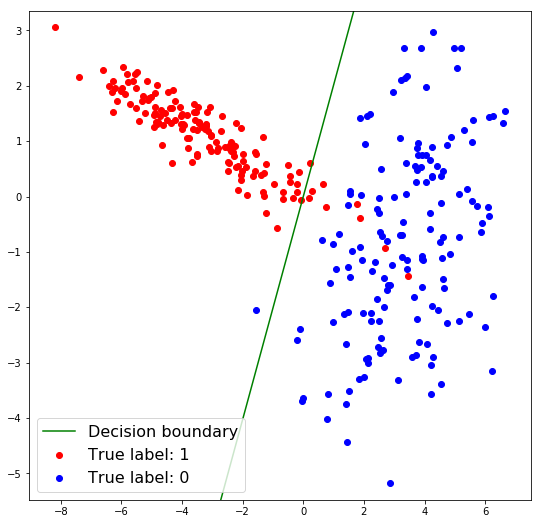

In [4]:
z = (X-1/2*(mu_1+mu_0))@sigma_inv@(mu_1-mu_0) + logit(pi)*np.ones(n)
pred = (z >= logit(1/2))
print("Missclassification rate: ", round(100*(1-accuracy_score(y,pred)),2), '%')

x_min, x_max = np.min(X[:,0]), np.max(X[:,0])
boundary_x = np.linspace(x_min, x_max, 1000)
boundary_y = [(logit(1/2)-gamma-beta_1*x)/beta_2 for x in boundary_x]

plt.figure(figsize = (9, 9))
plt.plot(boundary_x, boundary_y, c='g', label='Decision boundary')
plt.scatter(X_1[:, 0], X_1[:, 1], c='r', label='True label: 1')
plt.scatter(X_0[:, 0], X_0[:, 1], c='b', label='True label: 0')
plt.ylim(np.min(X[:,1])-0.3,np.max(X[:,1])+0.3)
plt.legend(loc="lower left", fontsize=16)
plt.savefig('C_lda.eps', format='eps', dpi=1000, bbox_inches='tight')
plt.show()



### Test

Missclassification rate:  4.15 %


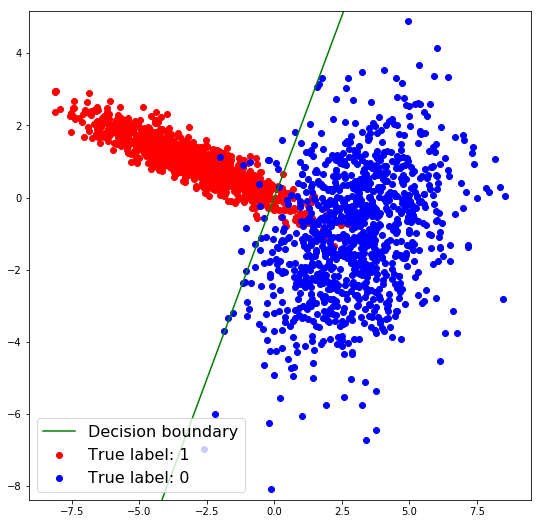

In [5]:
X, y = B_test[:,[0,1]], B_test[:,2]
X_1 = X[y==1]
X_0 = X[y==0]

z = (X-1/2*(mu_1+mu_0))@sigma_inv@(mu_1-mu_0) + logit(pi)*np.ones(B_test.shape[0])
pred = (z >= logit(1/2))
print("Missclassification rate: ", round(100*(1-accuracy_score(y,pred)),2), '%')


x_min, x_max = np.min(X[:,0]), np.max(X[:,0])
boundary_x = np.linspace(x_min, x_max, 1000)
boundary_y = [(logit(1/2)-gamma-beta_1*x)/beta_2 for x in boundary_x]

plt.figure(figsize = (9, 9))
plt.plot(boundary_x, boundary_y, c='g', label='Decision boundary')
plt.scatter(X_1[:, 0], X_1[:, 1], c='r', label='True label: 1')
plt.scatter(X_0[:, 0], X_0[:, 1], c='b', label='True label: 0')
plt.ylim(np.min(X[:,1])-0.3,np.max(X[:,1])+0.3)
plt.legend(loc="lower left", fontsize=16)
plt.show()

# Logistic regression

### Train

In [6]:
X, y = np.c_[ B_train[:,[0,1]], np.ones(B_train.shape[0])], B_train[:,2]
X_1 = X[y==1]
X_0 = X[y==0]
X_T = np.transpose(X)
w = np.array([[-0.1,-0.1,-0.1]])

lin_separable = 0 # SET this flag to 1 if the training data is linearly separable !!
max_iter = 100

if lin_separable: 
    z = np.transpose(X@np.transpose(w))
    pred = (z >= logit(1/2))
    while accuracy_score(y,pred.flatten()) < 1:
        grad = X_T@np.transpose(y-expit(w@X_T))
        hess = -X_T@(X*np.transpose(expit(-w@X_T)*expit(w@X_T)))
        w = w - np.transpose(inv(hess)@grad)
        z = np.transpose(X@np.transpose(w))
        pred = (z >= logit(1/2))
else:
    for _ in range(max_iter):
        grad = X_T@np.transpose(y-expit(w@X_T))
        hess = -X_T@(X*np.transpose(expit(-w@X_T)*expit(w@X_T)))
        w = w - np.transpose(inv(hess)@grad)
    z = np.transpose(X@np.transpose(w))
    pred = (z >= logit(1/2))
    

w = w.flatten()
w_1, w_2, b = w[0], w[1], w[2]
print("w:", w[:2], "\nb:", round(b,2))

w: [-1.71  1.02] 
b: 1.35


Missclassification rate:  2.0 %


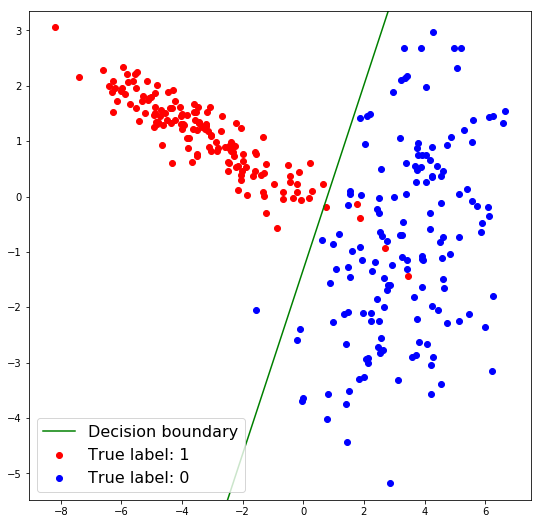

In [7]:
print("Missclassification rate: ", round(100*(1-accuracy_score(y,pred.flatten())),2), '%')

x_min, x_max = np.min(X[:,0]), np.max(X[:,0])
boundary_x = np.linspace(x_min, x_max, 1000)
boundary_y = [(logit(1/2)-b-w_1*x)/w_2 for x in boundary_x]

plt.figure(figsize = (9, 9))
plt.plot(boundary_x, boundary_y, c='g', label='Decision boundary')
plt.scatter(X_1[:, 0], X_1[:, 1], c='r', label='True label: 1')
plt.scatter(X_0[:, 0], X_0[:, 1], c='b', label='True label: 0')
plt.ylim(np.min(X[:,1])-0.3,np.max(X[:,1])+0.3)
plt.legend(loc="lower left", fontsize=16)
plt.savefig('C_log.eps', format='eps', dpi=1000, bbox_inches='tight')
plt.show()

### Test

Missclassification rate:  4.3 %


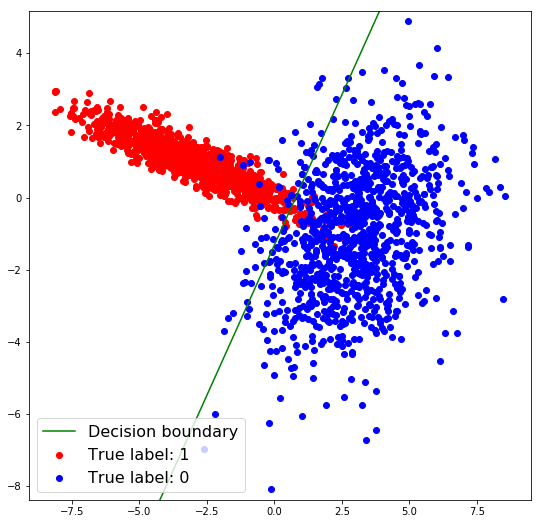

In [8]:
X, y = np.c_[ B_test[:,[0,1]], np.ones(B_test.shape[0])], B_test[:,2]
X_1 = X[y==1]
X_0 = X[y==0]

z = np.transpose(X@np.transpose(w))
pred = (z >= logit(1/2))
print("Missclassification rate: ", round(100*(1-accuracy_score(y,pred)),2), '%')

x_min, x_max = np.min(X[:,0]), np.max(X[:,0])
boundary_x = np.linspace(x_min, x_max, 1000)
boundary_y = [(logit(1/2)-b-w_1*x)/w_2 for x in boundary_x]

plt.figure(figsize = (9, 9))
plt.plot(boundary_x, boundary_y, c='g', label='Decision boundary')
plt.scatter(X_1[:, 0], X_1[:, 1], c='r', label='True label: 1')
plt.scatter(X_0[:, 0], X_0[:, 1], c='b', label='True label: 0')
plt.ylim(np.min(X[:,1])-0.3,np.max(X[:,1])+0.3)
plt.legend(loc="lower left", fontsize=16)
plt.show()

# Linear regression

### Train

In [9]:
X, y = np.c_[ B_train[:,[0,1]], np.ones(B_train.shape[0])], B_train[:,2]
X_1 = X[y==1]
X_0 = X[y==0]
X_T = np.transpose(X)

w = inv(X_T@X)@X_T@y

w_1, w_2, b = w[0], w[1], w[2]
print("w:", w[:2], "\nb:", round(b,2))

w: [-0.1   0.05] 
b: 0.5


Missclassification rate:  3.0 %


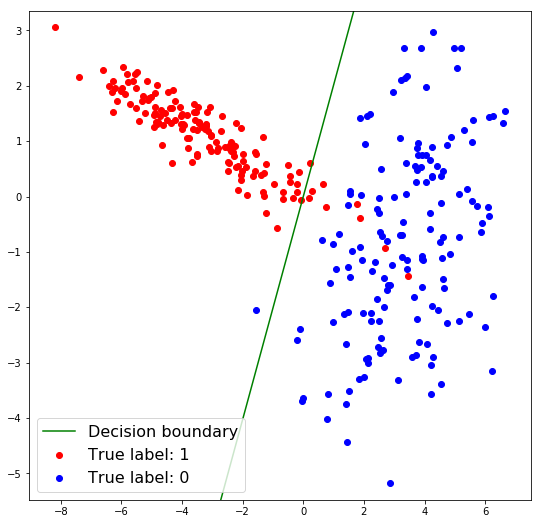

In [10]:
z = w@X_T
pred = (z >= 1/2)
print("Missclassification rate: ", round(100*(1-accuracy_score(y,pred)),2), '%')

x_min, x_max = np.min(X[:,0]), np.max(X[:,0])
boundary_x = np.linspace(x_min, x_max, 1000)
boundary_y = [(1/2-b-w_1*x)/w_2 for x in boundary_x]

plt.figure(figsize = (9, 9))
plt.plot(boundary_x, boundary_y, c='g', label='Decision boundary')
plt.scatter(X_1[:, 0], X_1[:, 1], c='r', label='True label: 1')
plt.scatter(X_0[:, 0], X_0[:, 1], c='b', label='True label: 0')
plt.ylim(np.min(X[:,1])-0.3,np.max(X[:,1])+0.3)
plt.legend(loc="lower left", fontsize=16)
plt.savefig('C_lin.eps', format='eps', dpi=1000, bbox_inches='tight')
plt.show()

### Test

Missclassification rate:  4.15 %


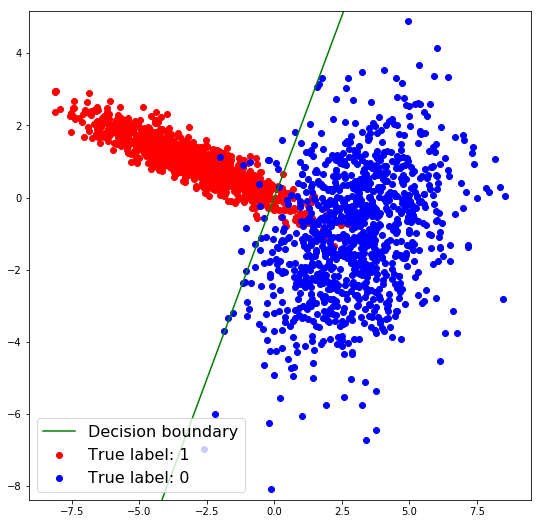

In [11]:
X, y = np.c_[ B_test[:,[0,1]], np.ones(B_test.shape[0])], B_test[:,2]
X_1 = X[y==1]
X_0 = X[y==0]
X_T = np.transpose(X)

z = w@X_T
pred = (z >= 1/2)
print("Missclassification rate: ", round(100*(1-accuracy_score(y,pred)),2), '%')

x_min, x_max = np.min(X[:,0]), np.max(X[:,0])
boundary_x = np.linspace(x_min, x_max, 1000)
boundary_y = [(1/2-b-w_1*x)/w_2 for x in boundary_x]

plt.figure(figsize = (9, 9))
plt.plot(boundary_x, boundary_y, c='g', label='Decision boundary')
plt.scatter(X_1[:, 0], X_1[:, 1], c='r', label='True label: 1')
plt.scatter(X_0[:, 0], X_0[:, 1], c='b', label='True label: 0')
plt.ylim(np.min(X[:,1])-0.3,np.max(X[:,1])+0.3)
plt.legend(loc="lower left", fontsize=16)
plt.show()

# QDA

### Train

In [12]:
X, y = B_train[:,[0,1]], B_train[:,2]
X_T = np.transpose(X)
n = B_train.shape[0]
n_1 = np.sum(y)
n_0 = n-n_1
X_1 = X[y==1]
X_0 = X[y==0]

pi = n_1/n
mu_1 = np.sum(X_1, axis=0)/n_1
mu_0 = np.sum(X_0, axis=0)/(n-n_1)
sigma_1 = (np.transpose(X_1-mu_1) @ (X_1-mu_1))/n_1
sigma_0 = (np.transpose(X_0-mu_0) @ (X_0-mu_0))/n_0
sigma_1inv = inv(sigma_1)
sigma_0inv = inv(sigma_0)

Q = sigma_0inv - sigma_1inv
beta = sigma_1inv@ np.transpose(mu_1)-sigma_0inv@ np.transpose(mu_0)
gamma = logit(pi)+1/2*(mu_0@sigma_0inv@np.transpose(mu_0)-mu_1@sigma_1inv@np.transpose(mu_1)
                      + np.log(det(sigma_0)) - np.log(det(sigma_1))
                      )
print("pi:", round(pi,2), "\nmu_1:", mu_1, "\nmu_0:", mu_0, "\nSigma_1:", sigma_1, "\nSigma_0:", sigma_0,
      "\nQ:", Q, "\nbeta:", sigma_inv@(mu_1-mu_0), "\ngamma:", round(gamma,2))

pi: 0.5 
mu_1: [-3.22  1.08] 
mu_0: [ 3.34 -0.84] 
Sigma_1: [[ 4.15 -1.33]
 [-1.33  0.52]] 
Sigma_0: [[2.54 1.06]
 [1.06 2.96]] 
Q: [[ -0.96  -3.85]
 [ -3.85 -11.06]] 
beta: [-1.92  0.95] 
gamma: 3.37


Missclassification rate:  1.33 %


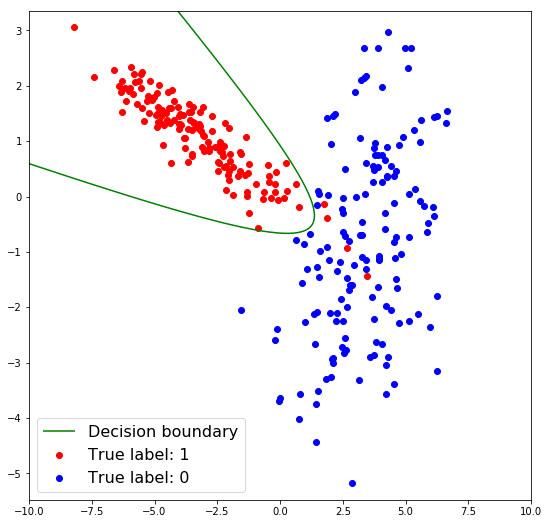

In [13]:
temp = np.zeros(n)
for i in range(n):
    temp[i] = 1/2*X[i,:]@(sigma_0inv - sigma_1inv)@np.transpose(X[i,:])
z = (temp + X@(sigma_1inv@ np.transpose(mu_1)-sigma_0inv@ np.transpose(mu_0))
     + (logit(pi)+1/2*(mu_0@sigma_0inv@np.transpose(mu_0)-mu_1@sigma_1inv@np.transpose(mu_1)
                      + np.log(det(sigma_0)) - np.log(det(sigma_1))
                      ))*np.ones(n)
    )
pred = (z >= logit(1/2))
print("Missclassification rate: ", round(100*(1-accuracy_score(y,pred)),2), '%')


x_min, x_max = np.min(X[:,0]), np.max(X[:,0])
def f(x, y):
    return 1/2*(Q[0][0]*x*x + Q[1][1]*y*y + 2*Q[0][1]*x*y) + beta[0]*x + beta[1]*y + gamma 

X_mesh, Y_mesh = np.meshgrid(np.linspace(-10, 10, 500), np.linspace(-10, 10, 500))
Z = f(X_mesh, Y_mesh)

plt.figure(figsize = (9, 9))
CS = plt.contour(X_mesh, Y_mesh, Z, logit(1/2), colors='g')
CS.collections[0].set_label('Decision boundary')
plt.scatter(X_1[:, 0], X_1[:, 1], c='r', label='True label: 1')
plt.scatter(X_0[:, 0], X_0[:, 1], c='b', label='True label: 0')
plt.ylim(np.min(X[:,1])-0.3,np.max(X[:,1])+0.3)
plt.legend(loc="lower left", fontsize=16)
plt.savefig('C_qda.eps', format='eps', dpi=1000, bbox_inches='tight')
plt.show()

### Test

Missclassification rate:  2.0 %


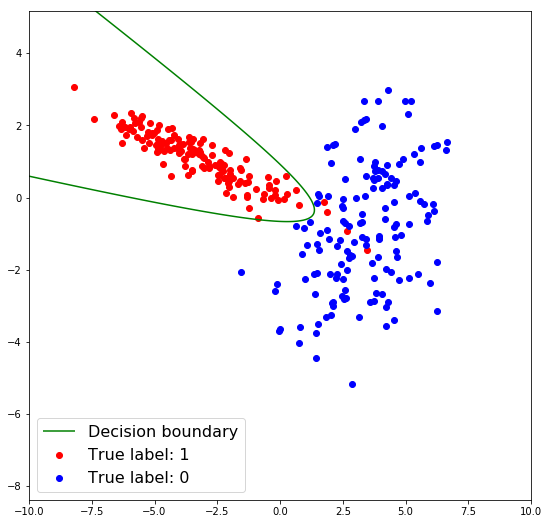

In [14]:
X, y = B_test[:,[0,1]], B_test[:,2]
n = B_test.shape[0]

temp = np.zeros(n)
for i in range(n):
    temp[i] = 1/2*X[i,:]@(sigma_0inv - sigma_1inv)@np.transpose(X[i,:])
z = (temp + X@(sigma_1inv@ np.transpose(mu_1)-sigma_0inv@ np.transpose(mu_0))
     + (logit(pi)+1/2*(mu_0@sigma_0inv@np.transpose(mu_0)-mu_1@sigma_1inv@np.transpose(mu_1)
                      + np.log(det(sigma_0)) - np.log(det(sigma_1))
                      ))*np.ones(n)
    )
pred = (z >= logit(1/2))
print("Missclassification rate: ", round(100*(1-accuracy_score(y,pred)),2), '%')

x_min, x_max = np.min(X[:,0]), np.max(X[:,0])
def f(x, y):
    return 1/2*(Q[0][0]*x*x + Q[1][1]*y*y + 2*Q[0][1]*x*y) + beta[0]*x + beta[1]*y + gamma 

X_mesh, Y_mesh = np.meshgrid(np.linspace(-10, 10, 500), np.linspace(-10, 10, 500))
Z = f(X_mesh, Y_mesh)

plt.figure(figsize = (9, 9))
CS = plt.contour(X_mesh, Y_mesh, Z, logit(1/2), colors='g')
CS.collections[0].set_label('Decision boundary')
plt.scatter(X_1[:, 0], X_1[:, 1], c='r', label='True label: 1')
plt.scatter(X_0[:, 0], X_0[:, 1], c='b', label='True label: 0')
plt.ylim(np.min(X[:,1])-0.3,np.max(X[:,1])+0.3)
plt.legend(loc="lower left", fontsize=16)
plt.show()